# 畳み込み演算
- 関数im2col()を用いて、畳み込み演算を実装しよう
- 単純な行列や、画像データに対して計算を行ってみよう

## 1. ライブラリの読み込み

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 画像データを扱うライブラリ
from PIL import Image

# MNISTデータセットの読み込み
from tensorflow.keras.datasets import mnist

# フィルタ演算を行列の積に変換する関数
from common.util import im2col

## 2. 疑似データに対する畳み込み

### 2-1. データの作成

In [2]:
img = np.array([
    [1, 2, 3, 0],
    [0, 1, 2, 3],
    [3, 0, 1, 2],
    [2, 3, 0, 1]
])

# im2col()に入力するため、軸を増やす
#（画像の枚数, チャネル数, 縦幅, 横幅）
img_expand = img.reshape(1, 1, img.shape[0], img.shape[1])

# データの形状と中身を表示
print(img_expand.shape)
img_expand

(1, 1, 4, 4)


array([[[[1, 2, 3, 0],
         [0, 1, 2, 3],
         [3, 0, 1, 2],
         [2, 3, 0, 1]]]])

### 2-2. データの配列を変換
- im2col()を用いてフィルタが適用される領域を抽出し、それらを列（column）に展開
- これにより、フィルタ演算を行列の積として扱うことができる

In [3]:
# 画像, フィルタサイズ（縦幅, 横幅）, ストライド, パディング幅
col = im2col(img_expand, 3, 3, stride=1, pad=0)

# データの形状と中身を表示
print("shape:", col.shape)
col

shape: (4, 9)


array([[1., 2., 3., 0., 1., 2., 3., 0., 1.],
       [2., 3., 0., 1., 2., 3., 0., 1., 2.],
       [0., 1., 2., 3., 0., 1., 2., 3., 0.],
       [1., 2., 3., 0., 1., 2., 3., 0., 1.]])

### 2-3. フィルタの作成

In [4]:
flt = np.array([
    [2,0,1],
    [0,1,2],
    [1,0,2]
])

# フィルタの形状と中身を表示
print("shape:", flt.shape)
flt

shape: (3, 3)


array([[2, 0, 1],
       [0, 1, 2],
       [1, 0, 2]])

### 2-4. フィルタの配列を変換

In [5]:
# 一次元配列に変換
flt_flat = flt.reshape(-1)
flt_flat

array([2, 0, 1, 0, 1, 2, 1, 0, 2])

### 2-5. 畳み込み演算の実行

In [6]:
# 行列の積をとることで畳み込む
img_y = np.dot(col, flt_flat)

# 二次元配列に戻す
img_y.reshape(2, 2)

array([[15., 16.],
       [ 6., 15.]])

## 3. モノクロ画像に対する畳み込み

### 3-1. 畳み込み演算を関数として定義
- 畳み込み演算の出力サイズは、以下の式で計算できる
$$O_h = \frac{I_h+2p-F_h}{s}+1$$
$$O_w = \frac{I_w+2p-F_w}{s}+1$$
    - $O_h, O_w$：出力の縦幅、横幅
    - $I_h, I_w$：入力の縦幅、横幅
    - $F_h, F_w$：フィルタの縦幅、横幅
    - $s$：ストライド
    - $p$：パディング幅

In [7]:
# 出力サイズを計算する関数
def calc_output_size(input_size, filter_size, stride, padding):
    output_h = 1 + (input_size[0] + 2*padding - filter_size[0]) / stride 
    output_w = 1 + (input_size[1] + 2*padding - filter_size[1]) / stride 
    
    # 小数点以下を切り捨て
    output_h = np.floor(output_h).astype(int)
    output_w = np.floor(output_w).astype(int)
    return output_h, output_w

# 二次元配列imgとfltの畳み込み演算
def conv2d(img, flt, stride, pad):
    # im2col()に入力するため、軸を増やす
    img_expand = img.reshape(1, 1, img.shape[0], img.shape[1])
    # im2col()でデータを変換
    # 画像, フィルタサイズ（縦幅, 横幅）, ストライド, パディング幅
    col = im2col(img_expand, flt.shape[0], flt.shape[1], stride=stride, pad=pad)
    
    # フィルタを一次元配列に変換
    flt_flat = flt.reshape(-1)
    # 行列の積をとることで畳み込む
    img_y = np.dot(col, flt_flat)
    
    # 出力サイズを計算
    output_size = calc_output_size(img.shape, flt.shape, stride, pad)
    
    # 出力データを二次元配列に戻す
    img_y = img_y.reshape(output_size[0], output_size[1])
    return img_y

### 3-2. データの読み込み

In [8]:
# 配列を画像として表示するための関数
def show_image(img): 
    # 配列をImageオブジェクトに変換
    pil_img = Image.fromarray(img)
    # Imageオブジェクトを画像として表示
    plt.imshow(pil_img)
    # グレースケールで表示
    plt.gray()
    plt.show()

X_train: (60000, 28, 28)
label = 5


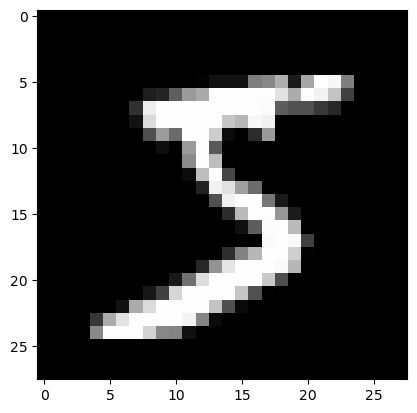

In [9]:
# MNISTデータセットの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データの形状を確認
print("X_train:", X_train.shape)

# クラスラベル
label = y_train[0]
# 画像データ（を表す配列）
img = X_train[0]

# クラスラベルの表示
print("label = %s"%label)
# 画像の表示
show_image(img)

### 3-3. フィルタの作成

In [10]:
# 平均化フィルタ
flt_mean = np.array([
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9]
])

# 合計値を表示
print("filter values sum:", flt_mean.sum())
# 中身を表示
flt_mean

filter values sum: 1.0


array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])

### 3-4. 畳み込み演算の実行

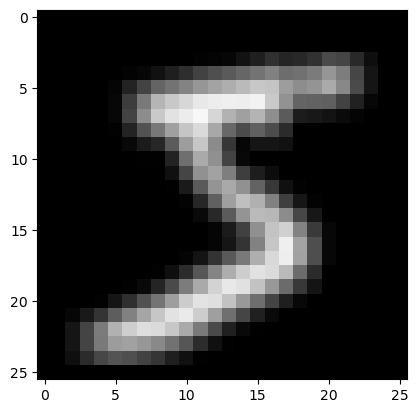

In [11]:
# 畳み込み演算
img_y = conv2d(img, flt_mean, stride=1, pad=0)

# 結果を画像として表示
show_image(img_y)

## 4. 様々なフィルタ

### 4-1. 垂直方向のエッジ抽出
- 横方向の画素値の差が抽出される

filter values sum: 0


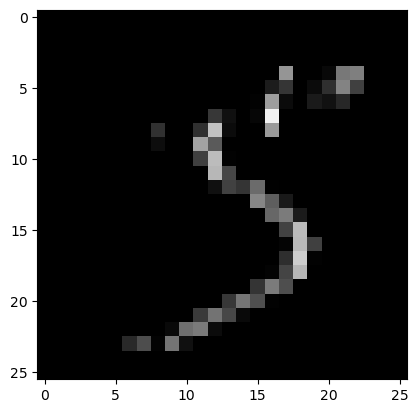

In [12]:
# フィルタの作成
flt_dv = np.array([
    [0,  0,  0],
    [0,  1, -1],
    [0,  0,  0]
])

# 合計値を表示
print("filter values sum:", flt_dv.sum())

# 畳み込み演算
img_y = conv2d(img, flt_dv, stride=1, pad=0)

# 結果を画像として表示
show_image(img_y)

### 4-2. 水平方向のエッジ抽出
- 縦方向の画素値の差が抽出される

filter values sum: 0


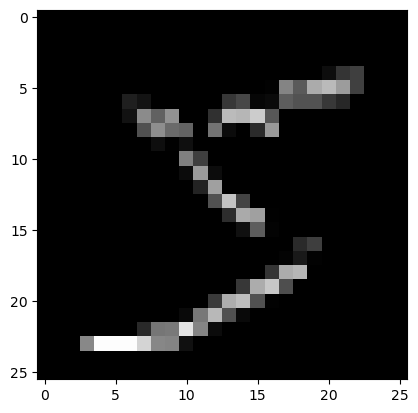

In [13]:
# フィルタの作成
flt_dh = np.array([
    [0,  0,  0],
    [0,  1,  0],
    [0, -1,  0]
])

# 合計値を表示
print("filter values sum:", flt_dh.sum())

# 畳み込み演算
img_y = conv2d(img, flt_dh, stride=1, pad=0)

# 結果を画像として表示
show_image(img_y)

## 5. カラー画像に対する畳み込み

### 5-1. 畳み込み演算を関数として定義

In [14]:
# 複数のチャネルともつ二次元配列imgとfltの畳み込み演算
def conv2d_multi_ch(img, flt, stride, pad):
    # 配列の軸を入れ替え
    # (高さ, 幅, チャネル数)　→　(チャネル数, 高さ, 幅)
    img_t = img.transpose(2, 0, 1) 
    
    # im2col()に入力するため、軸を増やす
    img_expand = img_t.reshape(1, img_t.shape[0], img_t.shape[1], img_t.shape[2])
    # im2col()でデータを変換
    # 画像, フィルタサイズ（縦幅, 横幅）, ストライド, パディング幅
    col = im2col(img_expand, flt.shape[0], flt.shape[1], stride=stride, pad=pad)
    
    # フィルタをチャネル数に合わせて増やす
    # 3チャネルの場合、flt_multi = np.array([flt, flt, flt])
    flt_multi = flt.copy()
    for i in range(img_t.shape[0]-1):    
        flt_multi = np.vstack((flt_multi, flt))
                               
    # フィルタを一次元配列に変換
    flt_flat = flt_multi.reshape(-1)
    # 行列の積をとることで畳み込む
    img_y = np.dot(col, flt_flat)
    
    # 入力画像のサイズをタプルにまとめる
    input_size = (img_t.shape[1], img_t.shape[2])
    
    # 出力サイズを計算
    output_size = calc_output_size(input_size, flt.shape, stride, pad)
    
    # 出力データを二次元配列に戻す
    img_y = img_y.reshape(output_size[0], output_size[1])
    return img_y

### 5-2. データの読み込み

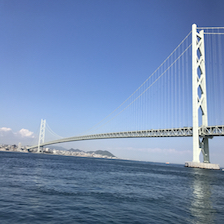

In [15]:
# Imageオブジェクトとして読み込み
img_ = Image.open("../../1_data/ch12/bridge.jpg")
img_

In [16]:
# NumPy配列に変換
img_ =  np.asarray(img_)

# データの形状を確認
# 3つ目の軸はチャネル（R・G・Bの三原色）
print("shape:", img_.shape)

shape: (224, 224, 3)


### 5-3. 畳み込み演算の実行

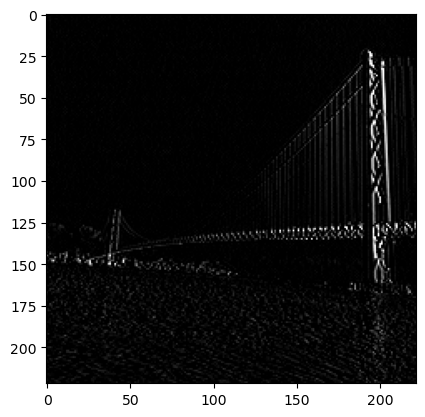

In [17]:
# 垂直方向（縦方向）のエッジ抽出
img_y = conv2d_multi_ch(img_, flt_dv, stride=1, pad=0)

# 結果を画像として表示
show_image(img_y)

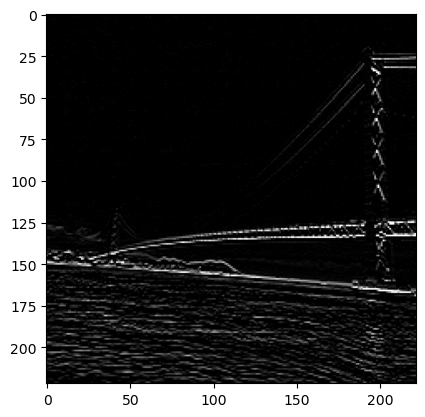

In [18]:
# 水平方向（横方向）のエッジ抽出
img_y = conv2d_multi_ch(img_, flt_dh, stride=1, pad=0)

# 結果を画像として表示
show_image(img_y)

### [演習]
- `bridge.jpg`以外の画像を読み込んで、畳み込み演算を試してみよう
    - 例：`"../../1_data/ch12/park.jpg"`


### [参考]
- OpenCV（画像処理ライブラリ）の[filter2d()](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04)という関数でも、畳み込み演算を行える
- ただし本講座の環境においては、バージョンの都合上OpenCVをインストールすることは困難